In [59]:
from google.colab import drive
drive.mount('/content/drive')
# drive.mount("/content/drive", force_remount=True)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [60]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.metrics import log_loss
from sklearn.decomposition import PCA

import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow.keras.backend as K
import tensorflow.keras.layers as L
import tensorflow.keras.models as M
import time
import sys
import os

In [61]:
data_train = pd.read_csv('/content/drive/MyDrive/lish-moa/train_features.csv')
test_df = pd.read_csv('/content/drive/MyDrive/lish-moa/test_features.csv')
targetns = pd.read_csv('/content/drive/MyDrive/lish-moa/train_targets_nonscored.csv')
train_target_df = pd.read_csv('/content/drive/MyDrive/lish-moa/train_targets_scored.csv')
sub = pd.read_csv('/content/drive/MyDrive/lish-moa/sample_submission.csv')

In [62]:
target_cols = train_target_df.columns[1:]
N_TARGETS = len(target_cols)
print(data_train.shape)

(23814, 876)


In [63]:
cells = [col for col in data_train.columns if col.startswith('c-')]
genes = [col for col in data_train.columns if col.startswith('g-')]

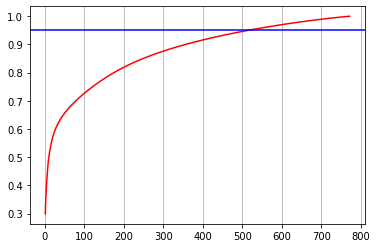

In [64]:
#Deciding the number of components for gene features
data = pd.concat([pd.DataFrame(data_train[genes]), pd.DataFrame(test_df[genes])])
pca = PCA().fit(data)
xi = np.arange(1, 773, 1)
y = np.cumsum(pca.explained_variance_ratio_)
plt.plot(xi, y, color = 'red')
plt.axhline(y = 0.95, color = 'blue')
plt.grid(axis = 'x')

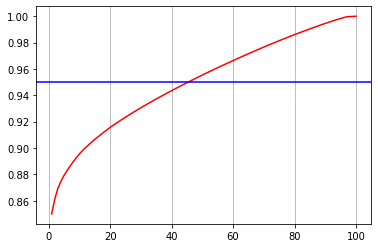

In [65]:
#Deciding the number of components for cell features
data = pd.concat([pd.DataFrame(data_train[cells]), pd.DataFrame(test_df[cells])])
pca = PCA().fit(data)
xi = np.arange(1, 101, 1)
y = np.cumsum(pca.explained_variance_ratio_)
plt.plot(xi, y, color = 'red')
plt.axhline(y = 0.95, color = 'blue')
plt.grid(axis = 'x')

In [70]:
# For g- features
#n_comp = 525
data = pd.concat([pd.DataFrame(data_train[genes]), pd.DataFrame(test_df[genes])])
data2 = (PCA(n_components = 525, random_state = 100).fit_transform(data[genes])) #50
train2 = data2[:data_train.shape[0]]
test2 = data2[-test_df.shape[0]:]

train2 = pd.DataFrame(train2, columns = [f'pca_G-{i}' for i in range(525)])
test2 = pd.DataFrame(test2, columns = [f'pca_G-{i}' for i in range(525)])

data_train = pd.concat((data_train, train2), axis = 1)
test_df = pd.concat((test_df, test2), axis = 1)

In [69]:
# For c- features
data = pd.concat([pd.DataFrame(data_train[cells]), pd.DataFrame(test_df[cells])])
data2 = (PCA(n_components = 45, random_state = 100).fit_transform(data[cells])) #15
train2 = data2[:data_train.shape[0]]
test2 = data2[-test_df.shape[0]:]

train2 = pd.DataFrame(train2, columns = [f'pca_C-{i}' for i in range(45)])
test2 = pd.DataFrame(test2, columns = [f'pca_C-{i}' for i in range(45)])
data_train = pd.concat((data_train, train2), axis = 1)
test_df = pd.concat((test_df, test2), axis = 1)
# data_train

In [71]:
from sklearn.feature_selection import VarianceThreshold

train_copy = data_train
var_thresh = VarianceThreshold(0.95)
data = data_train.append(test_df)
data_transformed = var_thresh.fit_transform(data.iloc[:, 4:])
data_transformed.shape

(27796, 1238)

In [72]:
train_df_trans = data_transformed[ : data_train.shape[0]]
test_df_trans = data_transformed[-test_df.shape[0] : ]

data_train = pd.DataFrame(data_train[['sig_id', 'cp_type', 'cp_time', 'cp_dose']].
                        values.reshape(-1, 4), columns = ['sig_id', 'cp_type', 
                                                          'cp_time', 'cp_dose'])
# train_df.head
data_train = pd.concat([data_train, pd.DataFrame(train_df_trans)], axis = 1)


test_df = pd.DataFrame(test_df[['sig_id', 'cp_type', 'cp_time', 'cp_dose']].
                       values.reshape(-1, 4), columns = ['sig_id', 'cp_type', 
                                                         'cp_time', 'cp_dose'])
# train_df.head
test_df = pd.concat([test_df, pd.DataFrame(test_df_trans)], axis = 1)
# train_df.head

In [73]:
search_row = dict(train_copy.iloc[0, 4:])
col_rela = {}
for i in np.arange(0, 868):
  for k, v in search_row.items():
    if data_train[i][0] == v.all():
      col_rela[i] = k
data_train = data_train.rename(columns = col_rela)
test_df = test_df.rename(columns = col_rela)


In [74]:
SEED = 1925
EPOCHS = 25
BATCH_SIZE = 128
FOLDS = 5
REPEATS = 2
LR = 0.0005
N_TARGETS = len(target_cols)

In [75]:
def multi_log_loss(y_true, y_pred):
  losses = []
  for col in y_true.columns:
    losses.append(log_loss(y_true.loc[:, col], y_pred.loc[:, col]))
  return np.mean(losses)

In [76]:
def preprocess_df(data):
  data.drop(['cp_type'], axis = 1, inplace = True)
  data.loc[:, 'cp_dose'] = data.loc[:, 'cp_dose'].map({'D1':0, 'D2':1})
  data.loc[:, 'cp_time'] = data.loc[:, 'cp_time'].map({24:0, 48:1, 72:2})
  return data

In [77]:
x_train = preprocess_df(data_train.drop(columns = "sig_id"))
x_test = preprocess_df(test_df.drop(columns = "sig_id"))
y_train = train_target_df.drop(columns = "sig_id")
# y_test = targetns.drop(columns = "sig_id")
N_FEATURES = x_train.shape[1]

In [78]:
x_train = x_train.astype({'cp_time':int})
x_test = x_test.astype({'cp_time':int})
# x_train

In [79]:
def create_model(col_num):
  model = tf.keras.Sequential()
  model.add(tf.keras.layers.Input(col_num))
  model.add(tf.keras.layers.BatchNormalization())
  model.add(tf.keras.layers.Dropout(0.2))
  model.add(tfa.layers.WeightNormalization(tf.keras.layers.Dense(6144, 
                                                                 activation = "relu")))#2048
  model.add(tf.keras.layers.BatchNormalization())
  model.add(tf.keras.layers.Dropout(0.5))
  model.add(tfa.layers.WeightNormalization(tf.keras.layers.Dense(6144, 
                                                                 activation = "relu")))#2048
  model.add(tf.keras.layers.BatchNormalization())
  model.add(tf.keras.layers.Dropout(0.5))
  model.add(tfa.layers.WeightNormalization(tf.keras.layers.Dense(206, 
                                                                 activation = "sigmoid")))#N_TARGETS
  model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = LR), 
                loss = 'binary_crossentropy', metrics = ["accuracy"])
  return model

In [80]:
EPOCHS = 25
BATCH_SIZE = 128
# BATCH_SIZE = 32

def build_train(repeat_number = 0, folds = 5):
  models = []
  oof_preds = y_train.copy()
  kfold = KFold(n_splits = folds, shuffle = True)
  for fold, (train_ind, val_ind) in enumerate(kfold.split(x_train)):
    # print(f'Training fold {fold + 1}')
    print('Training fold: ', fold+1)
    # fold = fold + 1
    cb_lr_schedule = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss', 
                                                          factor = 0.4, 
                                                          patience = 2, 
                                                          verbose = 1, 
                                                          min_delta = 0.0001, 
                                                          mode = 'auto')
    checkpoint_path = f'repeat:{repeat_number}_Fold:{fold}.hdf5'
    cb_checkpt = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, 
                                                    monitor = 'val_loss', 
                                                    verbose = 2,
                                                    save_best_only = True, 
                                                    save_weights_only = True, 
                                                    mode = 'min')
    
    # cb_checkpt = tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy', 
    #                                               verbose = 2, mode = 'max', 
    #                                               min_delta = 0.01)

    model = create_model(col_num = N_FEATURES)
    training_history = model.fit(x_train.values[train_ind], 
                                 y_train.values[train_ind], 
              validation_data = (x_train.values[val_ind], y_train.values[val_ind]),
              callbacks = [cb_lr_schedule, cb_checkpt], epochs = EPOCHS, 
              batch_size = BATCH_SIZE, verbose = 2)
    model.load_weights(checkpoint_path)
    oof_preds.loc[val_ind, :] = model.predict(x_train.values[val_ind])
    models.append(model)
    print('train:')
    print(list(zip(model.metrics_names, model.evaluate(x_train.values[train_ind], 
                                                       y_train.values[train_ind], 
                                                       verbose = 0, batch_size = 32))))
    print('val:')
    print(list(zip(model.metrics_names, model.evaluate(x_train.values[val_ind], 
                                                       y_train.values[val_ind], 
                                                       verbose = 0, batch_size = 32))))
  return models, oof_preds, training_history
  

In [ ]:
model = create_model(col_num = N_FEATURES)
model.summary()

In [ ]:
models = []
oof_preds = []
# seed_everything(SEED)
np.random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)
tf.random.set_seed(SEED)
# SEED_ARRAY = [0, 1, 2, 3, 4]
for i in range(1):
  m, oof, history = build_train(repeat_number = i, folds = FOLDS)
  models = models + m
  oof_preds.append(oof)

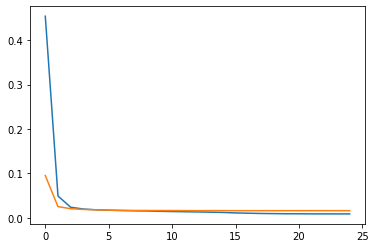

In [83]:
history.history['loss']
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

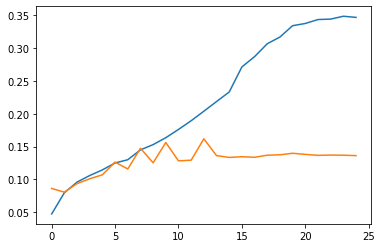

In [84]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

In [47]:
y_pred = models[1].predict(x_test)
models[1].evaluate(x_train, y_train)

745/745 [==============================] - 6s 8ms/step - loss: 0.0105 - accuracy: 0.3136


[0.010462705045938492, 0.31359705328941345]

In [48]:
test_preds = sub.copy()
test_preds[target_cols] = 0
for model in models:
  test_preds.loc[:, target_cols] += model.predict(x_test)
test_preds.loc[:, target_cols] /= len(models)
# test_preds.loc[x_test['cp_type'] == 0, target_cols] = 0
test_preds.to_csv('submission.csv', index = False)